In [1]:
# Importing the necessary packages
import numpy as np
import pandas as pd
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Reemplaza la ruta con la correcta y utiliza barras invertidas dobles o barras inclinadas
ruta_archivo = r'C:\Users\Asus\Documents\Programas Python\DAAD\datos_radiacion.csv'

# Leer el archivo CSV en un DataFrame
df_train = pd.read_csv(ruta_archivo).reset_index()

print(df_train)

      index  Radiacion Cumple Limite Permitido
0         0      2.763                      Si
1         1      3.980                      Si
2         2      6.571                      No
3         3      9.843                      No
4         4      4.505                      Si
...     ...        ...                     ...
9995   9995      3.961                      Si
9996   9996      3.863                      Si
9997   9997      5.121                      No
9998   9998      4.190                      Si
9999   9999      1.785                      Si

[10000 rows x 3 columns]


In [3]:
# Eliminar la columna de índice
df_train = df_train.drop(columns=['index'])

# Mostrar el DataFrame después de eliminar la columna de índice
print(df_train)

      Radiacion Cumple Limite Permitido
0         2.763                      Si
1         3.980                      Si
2         6.571                      No
3         9.843                      No
4         4.505                      Si
...         ...                     ...
9995      3.961                      Si
9996      3.863                      Si
9997      5.121                      No
9998      4.190                      Si
9999      1.785                      Si

[10000 rows x 2 columns]


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Radiacion                10000 non-null  float64
 1   Cumple Limite Permitido  10000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [5]:
# Asignar 0 a 'No' y 1 a 'Si', el resto se mantiene igual
df_train['Cumple Limite Permitido'] = df_train['Cumple Limite Permitido'].map({'Si': 1, 'No': 0})

# Mostrar el DataFrame resultante
print(df_train[['Cumple Limite Permitido']])

      Cumple Limite Permitido
0                           1
1                           1
2                           0
3                           0
4                           1
...                       ...
9995                        1
9996                        1
9997                        0
9998                        1
9999                        1

[10000 rows x 1 columns]


In [6]:
df_train

,Radiacion,Cumple Limite Permitido
0,2.763,1
1,3.980,1
2,6.571,0
3,9.843,0
4,4.505,1
...,...,...
9995,3.961,1
9996,3.863,1
9997,5.121,0
9998,4.190,1


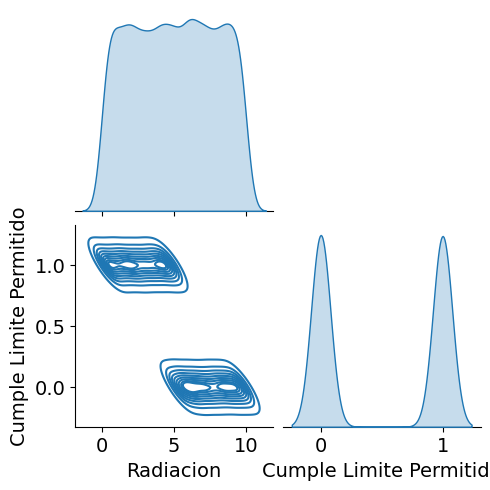

In [7]:
# Show a correlation scatter plot on the train data
import seaborn as sns
sns.pairplot(df_train, kind="kde" , corner=True)

<Axes: xlabel='Radiacion', ylabel='Density'>

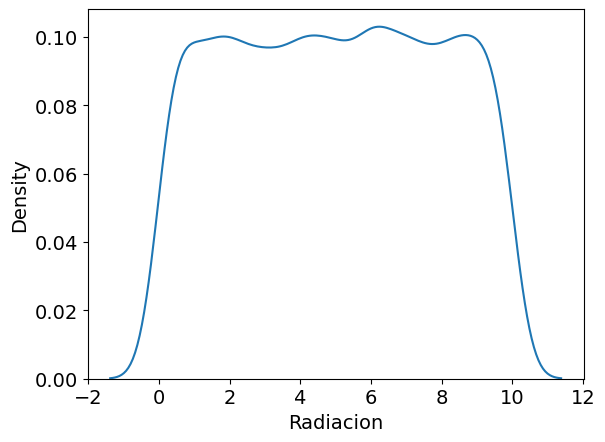

In [8]:
# Analisis de las distribuciones, luego de eliminar los outliers
sns.kdeplot(data=df_train, x='Radiacion')#, hue="glitch label", fill=True, common_norm=False)

In [9]:
#selecting useful columns in the test set:
X = df_train[['Radiacion']]
Y = df_train['Cumple Limite Permitido'].astype('category')

In [10]:
#Split the train data further into train and test sets
# Split training and test sets
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, shuffle = True)

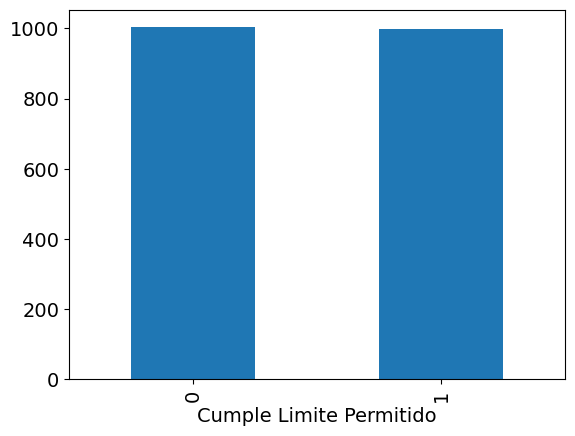

In [11]:
# Distribucion de las categorias
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
Y_test.value_counts().plot(kind="bar")
plt.savefig("glitch distribution.png", bbox_inches='tight', facecolor='w')

In [12]:
# Training routine
def train_model(XT, YT, Xt, Yt, model, **params):

    clf = model(**params)
    clf.fit(XT,YT)
    predictions = clf.predict(Xt)
    acc_train, acc_test = accuracy_score(YT, clf.predict(XT)), accuracy_score(Yt, predictions)
    print("Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(acc_train, acc_test))
    return acc_test

In [13]:
def transform(data):
    #n_dim = 2
    #pca = PCA(n_components=n_dim)
    #data = pca.fit_transform(data)

    std_scale = StandardScaler()
    data = std_scale.fit_transform(data)

    minmax_scale = MinMaxScaler((-1, 1))
    #data = minmax_scale.fit_transform(data)

    return data

### SVM

In [14]:
# defining parameter range
parameters = {"kernel":(['rbf']),
              'C': [0.1, 1, 10, 100, 1000],
              'gamma':[1, 0.1, 0.001, 0.0001]}
svc = SVC()
grid = GridSearchCV(svc, parameters, verbose=3, n_jobs=-1)

In [15]:
# Classical fit
inicio = time.time()

grid.fit(X_train, Y_train)

fin = time.time()
print(f'Tiempo de ejecucion: {fin-inicio}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de ejecucion: 29.21995234489441


In [16]:
train_model(X_train, Y_train, X_test, Y_test, SVC, C= grid.best_params_['C'], kernel = grid.best_params_['kernel'], gamma = grid.best_params_['gamma'])

Train accuracy: 1.0000, Test accuracy: 1.0000


1.0

### RANDOM FOREST

In [17]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, Y_train, X_test, Y_test, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
    # Crear el clasificador de Random Forest
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # Puedes ajustar la semilla aleatoria si es necesario
    )

    # Entrenar el modelo
    rf_classifier.fit(X_train, Y_train)

    # Hacer predicciones en el conjunto de entrenamiento
    train_predictions = rf_classifier.predict(X_train)

    # Calcular la precisión en el conjunto de entrenamiento
    train_accuracy = accuracy_score(Y_train, train_predictions)

    # Hacer predicciones en el conjunto de prueba
    test_predictions = rf_classifier.predict(X_test)

    # Calcular la precisión en el conjunto de prueba
    test_accuracy = accuracy_score(Y_test, test_predictions)

    # Imprimir la precisión con dos decimales
    print(f'Precisión del modelo de Random Forest en el conjunto de entrenamiento: {train_accuracy:.6f}')
    print(f'Precisión del modelo de Random Forest en el conjunto de prueba: {test_accuracy:.6f}')

    # Devolver el modelo entrenado
    return rf_classifier

# Uso del modelo
trained_rf_model = train_random_forest(X_train, Y_train, X_test, Y_test, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)


Precisión del modelo de Random Forest en el conjunto de entrenamiento: 1.000000
Precisión del modelo de Random Forest en el conjunto de prueba: 1.000000


### KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def train_knn(X_train, Y_train, X_test, Y_test, n_neighbors):
    # Crear el clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Entrenar el modelo
    knn_classifier.fit(X_train, Y_train)

    # Hacer predicciones en el conjunto de entrenamiento
    train_predictions = knn_classifier.predict(X_train)

    # Calcular la precisión en el conjunto de entrenamiento
    train_accuracy = accuracy_score(Y_train, train_predictions)

    # Hacer predicciones en el conjunto de prueba
    test_predictions = knn_classifier.predict(X_test)

    # Calcular la precisión en el conjunto de prueba
    test_accuracy = accuracy_score(Y_test, test_predictions)

    # Imprimir la precisión con dos decimales
    print(f'Precisión del modelo KNN en el conjunto de entrenamiento: {train_accuracy:.6f}')
    print(f'Precisión del modelo KNN en el conjunto de prueba: {test_accuracy:.6f}')

    # Devolver el modelo entrenado
    return knn_classifier

# Uso del modelo
trained_knn_model = train_knn(X_train, Y_train, X_test, Y_test, n_neighbors=3)


Precisión del modelo KNN en el conjunto de entrenamiento: 1.000000
Precisión del modelo KNN en el conjunto de prueba: 1.000000
